In [1]:
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
import astropy.units as u

# Parámetros orbitales
R_EARTH = 6378.137  # Radio de la Tierra en km
GM = 398600.4405  # km^3/s^2
a = 1.30262 * R_EARTH  # Semi-eje mayor en km
e = 0.16561  # Excentricidad
omega = np.radians(15)  # Argumento del pericentro en radianes



# Tiempos en UTC
tp = Time("2025-03-31 00:00:00", format="iso", scale="utc")  
t = Time("2025-04-01 00:00:00", format="iso", scale="utc") 

In [2]:
def position(t):
    # Calcular intervalo de tiempo en segundos
    delta_t = (t - tp).to_value('sec')

    # Calcular anomalía media l
    l = np.sqrt(GM / a**3) * delta_t  # Anomalía media

    # Resolver ecuación de Kepler con Newton-Raphson
    tol = 1.2834e-6
    max_iter = 100
    E = l  # Primera aproximación

    for _ in range(max_iter):
        f_E = E - e * np.sin(E) - l
        f_E_deriv = 1 - e * np.cos(E)
        E_new = E - f_E / f_E_deriv

        if abs(E_new - E) < tol:
            E = E_new
            break
        E = E_new

    # Calcular anomalía verdadera f
    f = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))

    # Calcular coordenadas r y φ
    r = a * (1 - e**2) / (1 + e * np.cos(f))
    phi = f + omega  # Coordenada angular

    return r, phi

r_t, phi_t = position(t)

print(f"r(t) = {r_t:.6f} km")
print(f"φ(t) = {np.degrees(phi_t):.6f} grados")

r(t) = 9658.322106 km
φ(t) = 185.570504 grados


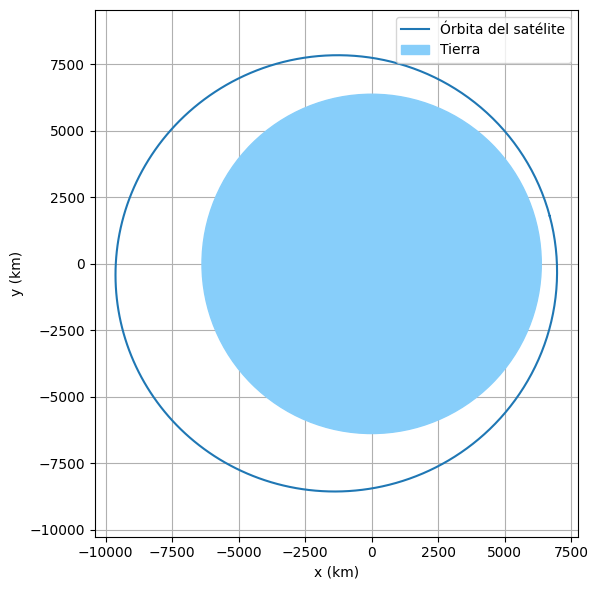

In [3]:
def orbit():
    """Grafica la órbita completa del satélite."""

    # Crear una lista de tiempos desde tp hasta un periodo orbital completo
    T_orbital = 2 * np.pi * np.sqrt(a**3 / GM)  # periodo orbital [s]
    tiempos = np.linspace(0, T_orbital, 200)    # 200 puntos a lo largo de una órbita

    r_vals = []
    phi_vals = []

    for dt in tiempos:
        t_new = tp + dt * u.s  
        r_t, phi_t = position(t_new)  # Función que devuelve r (en km) y ángulo (en rad)
        r_vals.append(r_t)
        phi_vals.append(phi_t)

    # Convertir a coordenadas cartesianas
    x = [r * np.cos(phi) for r, phi in zip(r_vals, phi_vals)]
    y = [r * np.sin(phi) for r, phi in zip(r_vals, phi_vals)]

    # Graficar
    plt.figure(figsize=(6,6))
    plt.plot(x, y, label='Órbita del satélite', linewidth=1.5)
    
    # Dibujar la Tierra
    Tierra = plt.Circle((0, 0), radius=R_EARTH, color='lightskyblue', label='Tierra', zorder=5)
    plt.gca().add_patch(Tierra)

    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


orbit()

In [4]:
def date(r0):
    # Verificar que r0 esté dentro de los límites orbitales
    if r0 < a * (1 - e) or r0 > a * (1 + e):
        raise ValueError("El valor de r0 está fuera de los límites de la órbita.")
    
    # Resolver la anomalía verdadera f
    cos_f = (a * (1 - e**2) / r0 - 1) / e
    f = np.arccos(cos_f)

    # Resolver la anomalía excéntrica E (primera aproximación)
    tan_E2 = np.sqrt((1 - e) / (1 + e)) * np.tan(f / 2)
    E = 2 * np.arctan(tan_E2)


    # Calcular la anomalía media l
    l = E - e * np.sin(E)

    # Calcular la frecuencia media n y el dt
    n = np.sqrt(GM/a**3)
    dt = (l / n)* u.s

    # Calcular el tiempo t
    t = tp + dt  # Tiempo en segundos desde tp
    return Time(t, format="iso", scale="utc")

# Ejemplo de uso
r0 = 1.5 * R_EARTH
print(f"El satélite alcanza r0 = {r0:.4f} km en el tiempo: {date(r0)}")


El satélite alcanza r0 = 9567.2055 km en el tiempo: 2025-03-31 00:53:09.883
